Sheet 2.5: Introduction to HuggingFace & LMs
========================
**Author**: Polina Tsvilodub

## Introduction: ML models
In the previous sheets, we have learned how to explicitly define neural networks and recurrent language models using native PyTorch. Further, we have seen the core steps of machine learning workflows with any kind of model, in general:
1. prepare data (sheet 1.1, respective steps in sheets 2.2-2.4)
2. define model architecture (i.e., define which layers with which parameters the network should have)
3. train model on data
4. evaluate model (sheet 2.4; more on evaluation of language models to come in future sessions)

The contents of the single steps differ by application (e.g., we use different kinds of data nad models to train an image classifier vs. to train a language model), but the general structure of the process is the same.

With this background, in principle, you should be able to put together any well-known neural network yourself! (e.g., implement Llama-3 or GPT-3)! (assuming sufficient time and access to information like PyTorch docs, details of the architecture, maybe some concepts from the next lecture, of course)

However, putting together the network (i.e., specifying all the layers, their sizes, implementing the forward pass through the net etc.) does *not* mean that you will be able to use the model for generating predictions in practice. Generating predictions (= running inference) on new inputs (e.g., predicting continuations of new input texts or classifying new images) is the purpose of creating a machine learning model -- we build them because we want to automate these tasks. Ideally, we want the model to *generalize well* -- to be able to handle inputs for that the model was not trained on and still perform the task correctly (e.g., produce a sensible text completion for an entirely new text input).

For generating predictions, we need the **trained** model, i.e., we need not just the definition of the model, but also the *model weights* set to optimized values that result from (successful) training. That is, we need the values of all the weight matrices (we have seen those in sheet 2.3). In practice, successful training of state-of-the-art models is quite costly and data-hungry (at least for creating actually useful models).

**NB**: The practical sheets will try to be consistent and use the term "architecture" to refer to the more abstract definition, carcass, of a model (i.e,. the specific layer types and parameterizations underlying the model), and the term "model" for the particular instatiation with particular weights of that model configuration. When referring to a specific model instance, there are different important concepts / terms:
* **pretrained** model: this is commonly used in the domains of NLP and computer vision (CV) where models are usually first trained on a very large collection of data to learn their task (in general). In the context of NLP, this refers to a model that has been trained to predict the next word on a large collection of text (e.g., on the Pile which we have seen in sheet 1.1). On a high level, this step can be thought of as the step where the model learns to predict fluent language in general. In the context of CV, this often refers to a model that has been trained to classify images on the ImageNet dataset.
* **fine-tuned** model: this refers to a pretrained model that has been further trained on a *task-specific*, or, generally curated and therefore, usually smaller, dataset. This step can be thought of as optimizing the model for a particular task, like predicting texts in a particular domain (e.g., movie reviews). This is usually done based on a pretrained model because curated datasets are often too small to learn a task from scratch well.

The term "trained" model will be mostly used as an umbrella terms for both types of models.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.5.1: ML models workflow </span></strong>
> 1. Given examples from the previous sheets, in your own words, describe the difference between *training* a model and running *inference* with a model. (Understanding this is absolutely critical; please ask questions if have any doubts!)
> 2. Suppose you want to train the model GPT-2 to generate IMDB movie reviews. In your own words (few intuitive sentences), describe the highlevel steps that you would do to accomplish this task. 

## HuggingFace 🤗

Luckily, there are many popular *open-source* models, i.e., those for which the architecture and the weights have been made freely accessible by the developers: e.g., GPT-2, the LLama models, BERT etc. In contrast, e.g., GPT-4 is *closed-source* -- we don't know exactly which layers with which configurations are inside the model and we cannot access the weights ourselves; they are only hosted by OpenAI and we can send our input data to their servers and get back predictions (by using the OpenAI API).

Open-source models are frequently used by the community and have been made available via platforms and packages which provide an easy interface for loading pretrained models, generating predictions from these pretrained models, or training models from scratch. The by-far most used platform for open-source resources which we will heavily use in this course is [**HuggingFace**](https://huggingface.co/). HuggingFace provides infrastructure for working with many different types of machine learning models (for working with audio, vision, language tasks), but, as you might guess, we will be focusing on functionality relevant to language modeling. HuggingFace will often be abbreviated as HF throughout the sheets.

Here is a high-level overview of all the nice things that HuggingFace provides: 
* (most relevant for us) the packages [`transformers`](https://huggingface.co/docs/transformers/en/index) and [`datasets`](https://huggingface.co/docs/datasets/index) which we already installed alst week. These allow easy access and workflow with models and with datasets.
  * Overviews, guides, tutorials for different tasks that can be done with `transformers`, docs for different models as well as the documentation of the API can be found [here](https://huggingface.co/docs/transformers/index).
  * The same resources for `datasets` can be found [here](https://huggingface.co/docs/datasets/index).
* The (online) HF platform called HuggingFace Hub actually stores trained model weights (also sometimes called checkpoints) and datasets. They are downloaded to the local machine when accessed through the `transformers` or `datasets` package. Available models can be browsed [here](https://huggingface.co/models); available datasets can be browsed [here](https://huggingface.co/datasets). 
  * In order to *upload* yourown resources to HF Hub and in order to access some models (inclding LLama-2), you need a free account. It can easily be created on HF. So far, an account is not required for following the class.
* The platform provides much more (feel free to explore! but also try not to feel overwhlemed if you are seeing HF for the first time). Here are some highlights most relevant to the course:
  * [NLP course](https://huggingface.co/learn/nlp-course/chapter1/1) which includes practical tutorials for common NLP tasks with transformers.
  * [`evaluate`](https://huggingface.co/docs/evaluate/index) package for computing common evaluation metrics (more on this in the next sessions)
  * (more advanced) packages for [accelerated](https://huggingface.co/docs/accelerate/index) and parallelized training on GPUs, via parameter-efficient fine-tuning ([PEFT](https://huggingface.co/docs/peft/index)) and more. 
  * `tokenizers` [package](https://huggingface.co/docs/tokenizers/index). However, we will only use functionality of pretrained tokenizers which are shipped together with models via transformers.


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.5.2: Familiarization with HuggingFace </span></strong>
>
> 1. Just for yourself, try to find whether the model BERT is available on HF. If yes, try get a sense of the kind of information that HF provides about available models.

### Working with LMs via 🤗 Transformers

We will dive right into using the `transformers` package ourselves. The learning goals for the remaining part of the sheett are:
* learn how to load a pretrained language model
* learn how to generate a prediction with the model
* learn about the `Trainer` class which allows to train from scratch or fine-tune the model (the following code is inspired by [this]( https://huggingface.co/docs/transformers/training) tutorial)

**NB:** this sheet uses the pretrained [GPT-2](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf), a causal (decoder-only) transformer model. We have not covered transformers in detail yet, so the set up of the model and some of the required set-up for using it are treated as a blackbox in this sheet. More in-depth explanations will follow the next lecture covering transformers.

There are two ways of generating predictions with a trained model available on HF. First, we will do so explicitly. The steps are: 
* load the pretrained model with its dedicated class
* tokenize some input text 
* generate predictions with greedy decoding (i.e., under the hood, compute forward passes through the model and retrieve the most likely token, given the previous input)
* convert the newly generated tokens back into human-readable strings

In [1]:
# import packages
# note: if you are on Colab, you might need to install some requirements
# as we did in Sheet 1.1. Otherwise, don't forget to activate your local environment

import transformers
from transformers import pipeline
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

/Users/swagatam/miniconda3/envs/ullm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# additioanlly, we need to install accelerate
# uncomment and run the following line on Colab or in your environment
# !pip install accelerate
# NOTE: in a notebook, reloading of the kernel might be required after installation if you get dependency errors with the transformers package

In [2]:
# define computational device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Device: {device}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Device: {device}")
else:
    device = torch.device("cpu")
    print(f"Device: {device}")

Device: mps


In [145]:
# define input text
input_text = "Natural language processing is "

# load pretrained model and respective tokenizer
# the class GPT2LMHeadModel initialized the "container" for the GPT-2
# architecture with an LM head - i.e., an output layer for predicting next tokens
# .from_pretrained loads the pretrained weights into the container
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
# load pretrained tokenizer belonging to GPT-2 (more on tokenizers next session)
##### YOUR CODE HERE ##### (Hint: you have seen how to do this in sheet 1.1)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# tokenize our input text
input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)
print("Tokenized text (input IDs) ", input_ids)

# generate predictions
prediction = model.generate(input_ids)
# decode the prediction (i.e., convert tokens back to text)
answer = tokenizer.decode(prediction[0])
print("Predicted continuation: ", answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Tokenized text (input IDs)  tensor([[35364,  3303,  7587,   318,   220]], device='mps:0')


/Users/swagatam/miniconda3/envs/ullm/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted continuation:  Natural language processing is  a very important part of the language processing process.
The first step


In [158]:
input_ids.shape

torch.Size([1, 5])

Alternatively, we can make use of transformer's `pipeline` -- a utility wrapper around these steps which makes it easier for us to generate predictions, without having to manually implement them. HF provides pipelines for many common tasks. 

In [4]:
# initialize the pipeline with the model of our choice
generator = pipeline(
    # specify task
    'text-generation', 
    model='gpt2'
)

# run the pipeline with default configs (note that the default is NOT greedy decoding)
pipe_output = generator(input_text)
print("Pipeline output: ", pipe_output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pipeline output:  [{'generated_text': 'Natural language processing is \xa0a very strong technology." In the US, it\'s not only computers, but also the Internet. This is why you would think the language industry would be a lot more excited about this and not only how amazing such a'}]


> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.5.3: Generating predictions </span></strong>
>
> 1. Come up with a different input string and generate a prediction. Would you consider the output a good prediction?
> 2. Change the code (explicit or implicit) by adding a few parameters so as to use *pure sampling* for predicting the output. How do the predictions change? (Hint: see slides for a reminder about decoding schemes and [docs](https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.TextGenerationPipeline) for practical implementation)


Another common use of pretrained models is to further fine-tune them on a specific dataset, e.g., to specialize them on generating text of a particular domain, or to train them for a specific task. The latter is often with a task-specific output *head* -- i.e., a different output layer is used. For instance, for classification tasks (like sentiment classification), a classification layer could be trained on a sentiment classification dataset, while keeping the rest of the network fixed from pretraining (or, frozen).

The following part shows how to fine-tune GPT-2 on a specific corpus -- IMDB movie reviews. Specifically, we will make use of the transformers `Trainer` class which provides convenient wrappers around different steps that need to be done in order to train a model. It essentially simplifies the implementation of the single substeps that are summarized under step 3 in the high-level overview of the ML workflow at the beginning of the sheet.

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.5.4: Training steps </span></strong>
>
> 1. As a reminder, using pseudo-code, list of concrete steps that constitute a single training step in a training loop. Take a look at the training loops in sheets 2.2 and 2.3 to compare your results. 
> 2. As you go through the following code, please complete it in spots which are commented with "### YOUR CODE HERE ###"

In [5]:
# load IMDB dataset
# dataset = load_dataset("truthful_qa", "generation")
dataset = load_dataset("stanfordnlp/imdb", split="train")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Generating test split: 100%|███| 25000/25000 [00:00<00:00, 836985.95 examples/s]
Generating unsupervised split: 100%|█| 50000/50000 [00:00<00:00, 892572.23 examp


In [12]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [15]:
print(dataset[0]['text'])

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

In [157]:
dataset.column_names

['text', 'label']

In [45]:
# set the pad token of the tokenizer which we loaded above
tokenizer.pad_token = tokenizer.eos_token
# set the side on which pad tokens should be added to the input (if required)
tokenizer.padding_side = "left" # why left??
# define a function to collate the data into batches and tokenize it
# this helper allows to massage the data such that it can be batched into the same 
# tensor representing a batch of inputs and can be used for training.
# specifically it creates *labels* for the model to predict
# note that the labels are the same as the input, **not** shifted by one token relative to the input
# the shifting is done automatically by the HF model class when the automatic loss computation is used
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

def tokenize(
        input_text, 
        max_length=64, #if 1024, then I see <|endoftext|> from the beginning, but why pad on the left?
        tokenizer=tokenizer
    ):
    """
   YOUR TEXT HERE.

    Arguments
    ---------
    input_text : YOUR TEXT HERE.
    max_length : YOUR TEXT HERE.

    Returns
    -------
    YOUR TEXT HERE.
    """
    tokenized_input = tokenizer(
        input_text["text"],
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    # mask padding tokens so that the model doesn't attend to them
    # more on masking next week
    tokenized_input["attention_mask"] = (tokenized_input["input_ids"] != tokenizer.pad_token_id).long()
    return {"input_ids": tokenized_input['input_ids'],
            "attention_mask": tokenized_input['attention_mask']}

tokenized_datasets = dataset.map(
    tokenize, batched=True, remove_columns=dataset.column_names
)

Map: 100%|███████████████████████| 25000/25000 [00:03<00:00, 6565.51 examples/s]


In [160]:
tokenized_datasets[0].keys()

dict_keys(['input_ids', 'attention_mask'])

In [46]:
# print a sample of the tokenized dataset
tokenizer.decode(tokenized_datasets[0]['input_ids'])

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "cont'

In [47]:
# since we don't want to fully fine-tune the model but rather learn 
# the basics of the set up, we will only use a small subset of the data
subsampled_dataset = tokenized_datasets.select(range(500))

In [48]:
# we inspect what the data_collator does
# it takes a list of dataset examples and creates batches out of it, here it creates a batch of 5 examples
# and input_ids[idx] == labels[idx]
out = data_collator([subsampled_dataset[i] for i in range(5)])
for key in out:
    print(f"Tensor shape -- {key}: {out[key].shape}")
    print(f"Tensor --  {key}: {out[key][0]}")

Tensor shape -- input_ids: torch.Size([5, 64])
Tensor --  input_ids: tensor([   40, 26399,   314,  3001,   327, 47269, 20958,    12,    56, 23304,
         3913,   422,   616,  2008,  3650,   780,   286,   477,   262, 10386,
          326, 11191,   340,   618,   340,   373,   717,  2716,   287, 15904,
           13,   314,   635,  2982,   326,   379,   717,   340,   373, 12000,
          416,   471,    13,    50,    13, 17112,   611,   340,  1683,  3088,
          284,  3802,   428,  1499,    11,  4361,   852,   257,  4336,   286,
         7328,  3177,   366,  3642])
Tensor shape -- attention_mask: torch.Size([5, 64])
Tensor --  attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Tensor shape -- labels: torch.Size([5, 64])
Tensor --  labels: tensor([   40, 26399,   314,  3001,   327, 47269, 20958,    12,    

In [64]:
input_batch = out['input_ids'][0]
labels_batch = out['labels'][0]
print(input_batch.shape, labels_batch.shape)

torch.Size([64]) torch.Size([64])


In [65]:
input_batch

tensor([   40, 26399,   314,  3001,   327, 47269, 20958,    12,    56, 23304,
         3913,   422,   616,  2008,  3650,   780,   286,   477,   262, 10386,
          326, 11191,   340,   618,   340,   373,   717,  2716,   287, 15904,
           13,   314,   635,  2982,   326,   379,   717,   340,   373, 12000,
          416,   471,    13,    50,    13, 17112,   611,   340,  1683,  3088,
          284,  3802,   428,  1499,    11,  4361,   852,   257,  4336,   286,
         7328,  3177,   366,  3642])

In [66]:
input_batch[..., :-1]

tensor([   40, 26399,   314,  3001,   327, 47269, 20958,    12,    56, 23304,
         3913,   422,   616,  2008,  3650,   780,   286,   477,   262, 10386,
          326, 11191,   340,   618,   340,   373,   717,  2716,   287, 15904,
           13,   314,   635,  2982,   326,   379,   717,   340,   373, 12000,
          416,   471,    13,    50,    13, 17112,   611,   340,  1683,  3088,
          284,  3802,   428,  1499,    11,  4361,   852,   257,  4336,   286,
         7328,  3177,   366])

In [67]:
labels_batch

tensor([   40, 26399,   314,  3001,   327, 47269, 20958,    12,    56, 23304,
         3913,   422,   616,  2008,  3650,   780,   286,   477,   262, 10386,
          326, 11191,   340,   618,   340,   373,   717,  2716,   287, 15904,
           13,   314,   635,  2982,   326,   379,   717,   340,   373, 12000,
          416,   471,    13,    50,    13, 17112,   611,   340,  1683,  3088,
          284,  3802,   428,  1499,    11,  4361,   852,   257,  4336,   286,
         7328,  3177,   366,  3642])

In [68]:
labels_batch[..., 1:], labels_batch[..., 1:].shape

(tensor([26399,   314,  3001,   327, 47269, 20958,    12,    56, 23304,  3913,
           422,   616,  2008,  3650,   780,   286,   477,   262, 10386,   326,
         11191,   340,   618,   340,   373,   717,  2716,   287, 15904,    13,
           314,   635,  2982,   326,   379,   717,   340,   373, 12000,   416,
           471,    13,    50,    13, 17112,   611,   340,  1683,  3088,   284,
          3802,   428,  1499,    11,  4361,   852,   257,  4336,   286,  7328,
          3177,   366,  3642]),
 torch.Size([63]))

**IMPORTANT:** it is key to understand the language modeling objective (i.e., mechanism used to train a model to predict the next token) and how it is implemented in practice. Conceptually, the LM objective is discussed at the beginning of the tutorial. In terms of implementation, the addition of special tokens and shifting happens within each transformers model, it is taken care of by the package. You can find and example for GPT-2 [here](https://github.com/huggingface/transformers/blob/571dd693b5d20754ecc472030903a94f92cfa9f8/src/transformers/models/gpt2/modeling_gpt2.py#L1100). As you can see, **the collator function above creates the labels that are used as target for prediction for us**. Please make sure that you understand this step and that you would be able to create labels, given an input, yourself. Note that if you manually implement the language modeling loss function (e.g., using the CrossEntropyLoss), you will have to do the processing of the inputs and labels yourself. 

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.5.5: Understanding Trainer </span></strong>
>
> The next cell defines the key configurations of the training in `TrainingArguments`. These are passed to the `Trainer` in order to instantiate a training loop. 
> 
> 1. Please use the documentation [here](https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/trainer#transformers.Trainer) to write short comments for each relevant line of the following code cell, so that you know what different training parameters there are.
> 2. What is the size of the training data? What is the size of the test data?

In [146]:
# define training arguments
args = TrainingArguments(
    output_dir="imdb_gpt2", # The output directory where the model predictions and checkpoints will be written.
    # overwrite_output_dir=True, #overwrite the content of the output directory
    per_device_train_batch_size=32, #16, 
    per_device_eval_batch_size=32, #16,
    
    evaluation_strategy="steps", # Evaluation is done (and logged) every `eval_steps`.
    eval_steps=5,
    
    logging_steps=1, # Number of update steps between two logs if logging_strategy="steps" (default).
    gradient_accumulation_steps=1,
    
    num_train_epochs=10, #1,
    
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True if device == "cuda" else False,
    push_to_hub=False,
    use_mps_device=True if device == "mps" else False,
    
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=subsampled_dataset,
    eval_dataset=subsampled_dataset,
)

In [147]:
# run the training of the model
trainer.train()

Step,Training Loss,Validation Loss
5,4.510100,4.116825
10,4.964400,4.275467
15,4.446100,3.880339
20,3.923600,3.636598
25,4.357400,3.980738
30,3.948000,3.431387
35,3.525100,3.226391
40,3.401700,3.014305
45,3.563100,2.912811
50,3.203500,3.125399


TrainOutput(global_step=160, training_loss=2.916428288817406, metrics={'train_runtime': 209.374, 'train_samples_per_second': 23.881, 'train_steps_per_second': 0.764, 'total_flos': 163307520000000.0, 'train_loss': 2.916428288817406, 'epoch': 10.0})

Note that **we did not explicitly pass a loss function to the training. The Trainer constructs it automatically.** However, we could also explicitly define the language modeling loss. For this, we need to override the `compute_loss()` method of the Trainer and build a custom Trainer with it. 

For each batch of `inputs` of shape [B=32, T=64], the prediction `logits` are of shape [B=T, T=64, C=50257]. How to interpret this?
---
Take a particular string in the input batch, say, `x[b]` which is a vector of size `T`, now for this vector, we want to predict another vector of size `T` that contains the next token predictions for the sequence `x[b, {0,1,2,...,t-1}]` (or simply `x[b, :t]`). Written more clearly (assuming a zero-based indexing):

```
x[b, {0}] should predict x[b, 1]
x[b, {0, 1}] should predict x[b, 2]
...
x[b, {0, 1, ..., T-2}] should predict x[b, T-1] (this is what we want, to predict the last token which is the answer key!)
```
and this is the reason behind shifting the inputs and targets for loss calculation earlier, we want to end inputs early (till `T-2`-th token), and the target is the same input array but starting from `1` to `T-1`, note that both these have now size `T-1`.

Now coming to `logits` it is a tensor of shape [B, T, C] when the input had been `x` of shape [B, T].
`logits[b, t, ...]` is a distribution over the next `(t+1)`-th predicted token for the sequence `x[b, {0, 1, ..., t}]`, so note that here `t` starts from 1 and goes till `T-1`, i.e.,
```
logits[b, 0, ...] ---> uses the sequence x[b, {0}] and is a distribution to predict x[b, 1] (target: x[b, 1])
logits[b, 1, ...] ---> uses the sequence x[b, {0, 1}] and is a distribution to predict x[b, 2] (target: x[b, 2])


logits[b, T-2, ...] --> uses the sequence x[b, {0, 1, ..., T-2}] and is a distribution to predict x[b, T-1] (target: x[b, T-1])
```
The last one is what we need here to predict the "answer key token" in order to answer the multiple choice question!


In [148]:
class IMDBTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)

        # manual computation of language modeling loss
        labels = inputs['labels']  # print(labels.shape) --> torch.Size([16, 64])
        logits = outputs.logits  # print(outputs.logits.shape) --> [16, 64, 50257]
        B, T, C = logits.shape

        # print(outputs.logits[..., :-1, :].shape)
        loss_function = torch.nn.CrossEntropyLoss()
        loss1 = loss_function(logits[..., :-1, :].contiguous().view(B*(T-1), C),
                              labels[..., 1:].contiguous().view(B*(T-1))
                             )
        
        loss = outputs.loss
        assert loss1.item() == loss.item(), 'something is wrong in loss calculation!' # sanity check
        
        return (loss, outputs) if return_outputs else loss

In [149]:
16*64, 16*63

(1024, 1008)

In [150]:
x = torch.randn((2, 10, 100))
y = torch.randn((2, 10))

# y

tensor([[[ 0.5362,  0.5246,  1.1412,  ..., -1.5910, -1.1360, -0.5226],
         [ 0.7165,  1.5335, -1.4510,  ..., -0.5890, -1.0340, -0.2179],
         [ 0.4146,  1.1566,  0.2691,  ...,  0.8541, -0.4901, -0.3595],
         ...,
         [ 0.5831,  0.0330, -1.2598,  ..., -1.2044, -0.4824, -0.8164],
         [-1.5844, -2.5447,  1.3719,  ..., -0.7124, -1.6171, -0.3590],
         [-0.1199,  0.9405,  0.4763,  ...,  0.8967, -0.2337,  0.0605]],

        [[-0.1850, -1.0381, -0.1013,  ..., -0.7502,  1.2355,  1.0141],
         [-0.6535,  1.4623,  0.1203,  ...,  1.0582,  0.1146,  1.9056],
         [ 0.5124, -0.9819,  1.1259,  ...,  0.0832, -0.9222, -0.3711],
         ...,
         [ 1.1887,  1.0021, -1.4647,  ..., -0.1410,  0.8008,  0.9251],
         [-0.5562,  1.1731,  0.6860,  ..., -0.3452, -0.7288, -1.4958],
         [-0.3543,  0.8893,  0.8924,  ..., -1.8930,  0.5651,  0.8413]]])

In [151]:
x[..., :-1, :].shape

torch.Size([2, 9, 100])

In [152]:
y[..., 1:].shape

torch.Size([2, 9])

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 2.5.6: CrossEntropyLoss [more advanced]</span></strong>
>
> 1. Implement an even more explicit definition of the loss function by using the `torch.nn.CrossEntropyLoss()` and the labels which are passed as part of the inputs instead of using outputs.loss. The respective docs can be found on the PyTorch website. NB: Make sure to correctly shift your labels.

In [153]:
## need to reinitialize model? because it is already trained by the regular trainer
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# use explicit trainer
explicit_trainer = IMDBTrainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=subsampled_dataset,
    eval_dataset=subsampled_dataset,
)

explicit_trainer.train()

Step,Training Loss,Validation Loss
5,4.057600,3.705219
10,4.095000,3.448643
15,4.514200,3.654313
20,3.584100,3.302715
25,3.359100,3.083275
30,3.456700,2.930611
35,3.177000,2.737638
40,2.817100,2.529520
45,2.867400,2.407414
50,2.521000,2.295037


TrainOutput(global_step=160, training_loss=2.247519689053297, metrics={'train_runtime': 221.1446, 'train_samples_per_second': 22.61, 'train_steps_per_second': 0.724, 'total_flos': 163307520000000.0, 'train_loss': 2.247519689053297, 'epoch': 10.0})

Finally, we want to inspect the training dynamics by plotting the training and evaluation losses. These can be accessed in the Trainer history. Ideally, both of them should decrease -- this would indicate successful optimization. Feel free to play around with training parameters and plot the losses to see what effects different values have.

In [154]:
# plot the train and evaluation losses
log_history = trainer.state.log_history

# wrangle the trainer logs into a dataframe for easier plotting
train_losses = []
test_losses = []
for d in log_history:
    if "loss" in d.keys():
        train_losses.append(d["loss"])
    elif "eval_loss" in d.keys():
        test_losses.append(d["eval_loss"])

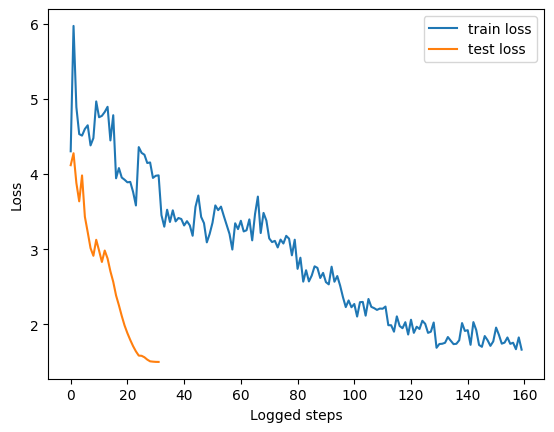

In [155]:
# plot
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("Logged steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

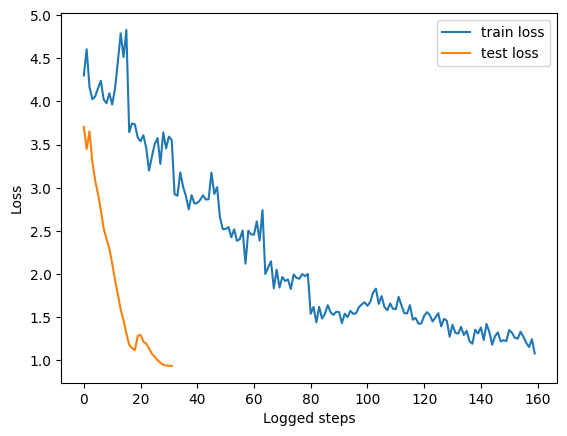

In [156]:
# plot the train and evaluation losses
log_history = explicit_trainer.state.log_history

# wrangle the trainer logs into a dataframe for easier plotting
train_losses = []
test_losses = []
for d in log_history:
    if "loss" in d.keys():
        train_losses.append(d["loss"])
    elif "eval_loss" in d.keys():
        test_losses.append(d["eval_loss"])

# plot
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("Logged steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Outlook

The code above used a GPT-2 specific class, `GPT2LMHeadModel`, to load the model. However, instead of the architecture-specific classes the so called AutoClass can often be used instead. It essentially "infers" the architecture from a configuration file that is retrieved when a model is downloaded from HF. In the next tutorials, you will often see subclasses of this being used. You can find more (optional) information [here](https://huggingface.co/docs/transformers/model_doc/auto).